Bernstein-Vazirani Benchmark Program - Cirq
... execution starting at Jun 06, 2024 08:24:30 UTC
************
Executing [2] circuits with num_qubits = 2
Average Creation, Elapsed, Execution Time for the 2 qubit group = 0.0, 0.002, 0.001 secs
Average Hellinger, Normalized Fidelity for the 2 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 3
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.0, 0.003, 0.001 secs
Average Hellinger, Normalized Fidelity for the 3 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 4
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.0, 0.003, 0.002 secs
Average Hellinger, Normalized Fidelity for the 4 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 5
Average Creation, Elapsed, Execution Time for the 5 qubit group = 0.0, 0.004, 0.002 secs
Average Hellinger, Normalized Fidelity for the 5 qubit group = 1.0, 1.0

************
Executing [3] circu

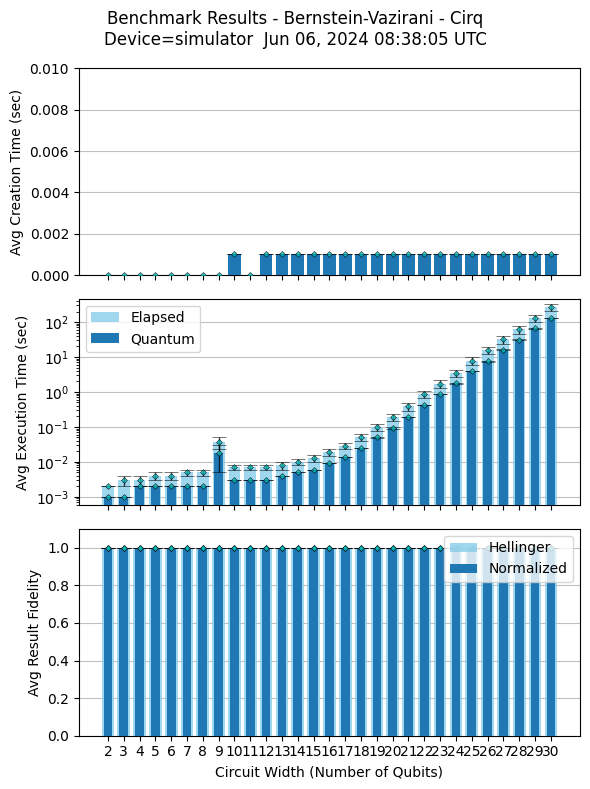

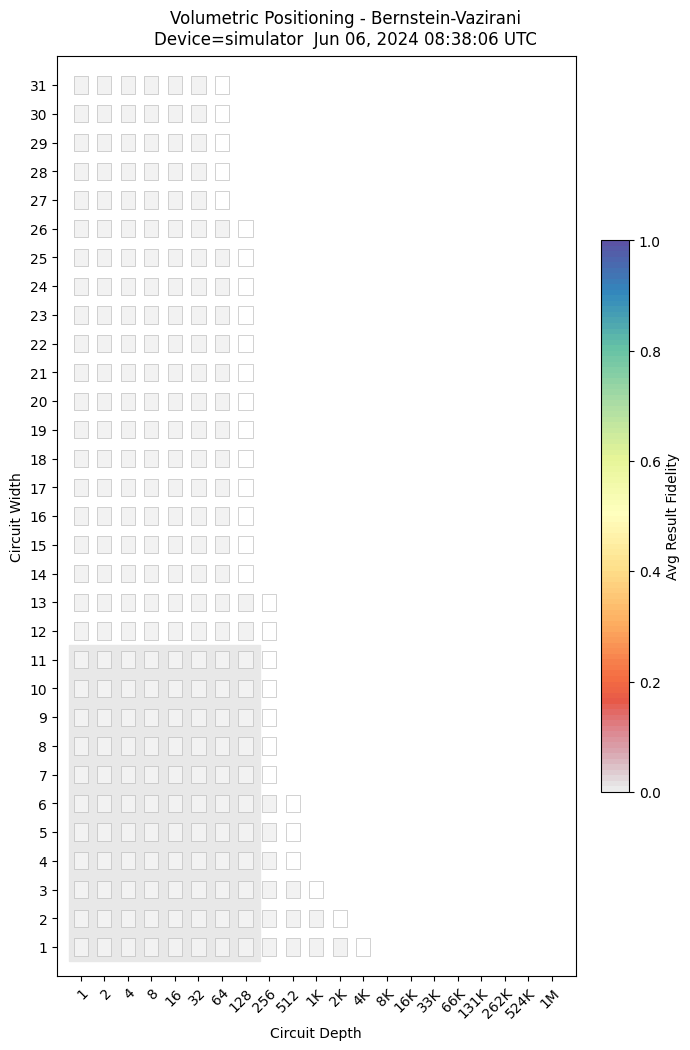

In [1]:
"""
Bernstein-Vazirani Benchmark Program - Cirq
"""

from collections import defaultdict
import sys
import time

import cirq
import numpy as np

sys.path[1:1] = [ "_common", "_common/cirq" ]
sys.path[1:1] = [ "../../_common", "../../_common/cirq" ]
import cirq_utils as cirq_utils
import execute as ex
import metrics as metrics

np.random.seed(0)

verbose = False

# saved circuits for display
QC_ = None
Uf_ = None

############### Circuit Definition

def create_oracle(num_qubits, input_size, secret_int):
    # allocate qubits
    qr = [cirq.GridQubit(i, 0) for i in range(num_qubits)]
    qc = cirq.Circuit()

    # perform CX for each qubit that matches a bit in secret string
    CNOT_exist = False
    s = ('{0:0'+str(input_size)+'b}').format(secret_int)
    for i_qubit in range(input_size):
        if s[input_size-1-i_qubit]=='1':
            qc.append(cirq.CNOT(qr[i_qubit], qr[input_size]))
            CNOT_exist = True
        else:
            qc.append(cirq.I(qr[i_qubit]))

    # Add identity to target qubit if no CNOT gate added
    if not CNOT_exist:
        qc.append(cirq.I(qr[input_size]))

    return cirq_utils.to_gate(num_qubits=num_qubits, circ=qc, name="Uf")

def BersteinVazirani (num_qubits, secret_int):
    
    # size of input is one less than available qubits
    input_size = num_qubits - 1
    
    # allocate qubits
    qr = [cirq.GridQubit(i, 0) for i in range(num_qubits)]
    qc = cirq.Circuit()

    # put ancilla in superposition
    qc.append(cirq.X(qr[num_qubits-1]))
    
    # start with Hadamard on all qubits, including ancilla
    for i_qubit in range(num_qubits):
         qc.append(cirq.H(qr[i_qubit]))

    #generate Uf oracle
    Uf = create_oracle(num_qubits, input_size, secret_int)
    qc.append(Uf.on(*qr))

    # end with Hadamard on all qubits, including ancilla
    for i_qubit in range(num_qubits):
         qc.append(cirq.H(qr[i_qubit]))

    # uncompute ancilla qubit, not necessary for algorithm
    qc.append(cirq.X(qr[input_size]))

    # measure all data qubits
    qc.append(cirq.measure(*[qr[i_qubit] for i_qubit in range(input_size)], key='result'))

    # save smaller circuit example for display
    global QC_, Uf_
    if QC_ == None or num_qubits <= 6:
        if num_qubits < 9: QC_ = qc
    if Uf_ == None or num_qubits <= 6:
        if num_qubits < 9: Uf_ = Uf

    # return a handle on the circuit
    return qc


############### Result Data Analysis

# Analyze and print measured results
# Expected result is always the secret_int, so fidelity calc is simple
def analyze_and_print_result (qc, result, num_qubits, secret_int, num_shots):

    # size of input is one less than available qubits
    input_size = num_qubits - 1

    # get measurement array
    measurements = result.measurements['result']

    # create counts distribution
    counts = defaultdict(lambda: 0)
    for row in measurements:
        counts["".join([str(x) for x in reversed(row)])] += 1
    if verbose: print(f"For secret int {secret_int} measured: {counts}")

    # create the key that is expected to have all the measurements (for this circuit)
    key = format(secret_int, f"0{input_size}b")
    
    # correct distribution is measuring the key 100% of the time
    correct_dist = {key: 1.0}

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist)
    
    return counts, fidelity


################ Benchmark Loop

# Execute program with default parameters
def run (min_qubits=2, max_qubits=30, max_circuits=3, num_shots=100,
        backend_id='simulator', provider_backend=None):

    print("Bernstein-Vazirani Benchmark Program - Cirq")

    # validate parameters (smallest circuit is 3 qubits)
    max_qubits = max(2, max_qubits)
    min_qubits = min(max(2, min_qubits), max_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler (qc, result, num_qubits, s_int, num_shots):  
     
        # determine fidelity of result set
        num_qubits = int(num_qubits)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(s_int), num_shots)
        metrics.store_metric(num_qubits, s_int, 'fidelity', fidelity)

    # Initialize execution module   with the result handler  
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend)

    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1):
    
        input_size = num_qubits - 1
        
        # determine number of circuits to execute for this group
        num_circuits = min(2**(input_size), max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # determine range of secret strings to loop over
        if 2**(input_size) <= max_circuits:
            s_range = list(range(num_circuits))
        else:
            s_range = np.random.choice(2**(input_size), num_circuits, False)
        
        # loop over limited # of secret strings for this
        for s_int in s_range:
            
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()
            qc = BersteinVazirani(num_qubits, s_int)
            metrics.store_metric(num_qubits, s_int, 'create_time', time.time()-ts)

            qc = cirq.Circuit(cirq.decompose(op) for op in qc.all_operations())
            
            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc, num_qubits, s_int, shots=num_shots)
        
        # execute all circuits for this group, aggregate and report metrics when complete
        ex.execute_circuits()
        metrics.aggregate_metrics_for_group(num_qubits)
        metrics.report_metrics_for_group(num_qubits)

    # Alternatively, execute all circuits, aggregate and report metrics
    #ex.execute_circuits()
    #metrics.aggregate_metrics_for_group(num_qubits)
    #metrics.report_metrics_for_group(num_qubits)

    # print a sample circuit
    # print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    # qr_state = [cirq.GridQubit(i, 0) for i in range(Uf_.num_qubits)]  # we need to create registers to print circuits in cirq
    # print("\nQuantum Oracle 'Uf' ="); print(cirq.Circuit(cirq.decompose(Uf_.on(*qr_state))) if Uf_ != None else " ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics("Benchmark Results - Bernstein-Vazirani - Cirq")

# if main, execute method
if __name__ == '__main__': run()
